In [3]:
!pip install pymupdf

In [1]:
import fitz
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os
import random
import shutil

dataset_dir = "font_data"
input_dir = "image"

def delete_folder_contents(folder_path):
    # フォルダ内の全てのファイルとサブフォルダを削除
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)  # サブフォルダの場合は再帰的に削除
        else:
            os.remove(file_path)  # ファイルの場合は削除

os.makedirs(os.path.join(dataset_dir,"train/input"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir,"train/target"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir,"val/input"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir,"val/target"), exist_ok=True)

delete_folder_contents(os.path.join(dataset_dir,"train/input"))
delete_folder_contents(os.path.join(dataset_dir,"train/target"))
delete_folder_contents(os.path.join(dataset_dir,"val/input"))
delete_folder_contents(os.path.join(dataset_dir,"val/target"))


# 画像切り出しの調整
height = 128
width = 512
x = 0
y = 30
lineh = 150
slidex = 100
linemax = 23
# 画像のコントラストを調整
contrast = 2

def generate_random_array(l, p):
    return ["val" if random.random() < p else "train" for _ in range(l)]

def proc(dataid,output_dir,input):
    print(f"-- {dataid} {input} --")
    # 各行をtrainとvalに分ける
    datatype = generate_random_array(linemax,5/ 100)
    # print(datatype)
    print(f"train: "+str(datatype.count("train")))
    print(f"val  : "+str(datatype.count("val")))
    # PDFファイルを開く
    doc = fitz.open(os.path.join(dataset_dir,input_dir,input))
    for i, page in enumerate(doc):
        images = page.get_images(full=True)
        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            filepath = os.path.join(dataset_dir,input_dir,f"{input_dir}.{image_ext}")
            with open(filepath, "wb") as img_file:
                img_file.write(image_bytes)

            # 画像を読み込む
            input_image = Image.open(filepath)
            # コントラストを調整する
            enhancer = ImageEnhance.Contrast(input_image)
            input_image = enhancer.enhance(contrast)

            # 切り出す領域を指定（左、上、右、下）
            inwidth, inheight = input_image.size
            for linen in range(linemax):
                sliden = 0
                while x+slidex*sliden+width < inwidth:
                    box = (x+slidex*sliden,y+lineh*linen,x+slidex*sliden+width,y+height+lineh*linen)
                    cropped_image = input_image.crop(box)
                    cropped_image.save(os.path.join(dataset_dir+"/"+datatype[linen]+"/"+output_dir,f"{dataid}-{linen}-{sliden}.png"))
                    sliden+=1



idlist = [1,2,3,4,5,6,7]

for i in idlist:
    proc(i,"input/",f"{i}-input.pdf")
    proc(i,"target/",f"{i}-target.pdf")

-- 1 1-input.pdf --
train: 23
val  : 0
-- 1 1-target.pdf --
train: 23
val  : 0
-- 2 2-input.pdf --
train: 23
val  : 0
-- 2 2-target.pdf --
train: 22
val  : 1
-- 3 3-input.pdf --
train: 22
val  : 1
-- 3 3-target.pdf --
train: 21
val  : 2
-- 4 4-input.pdf --
train: 22
val  : 1
-- 4 4-target.pdf --
train: 23
val  : 0
-- 5 5-input.pdf --
train: 21
val  : 2
-- 5 5-target.pdf --
train: 23
val  : 0
-- 6 6-input.pdf --
train: 21
val  : 2
-- 6 6-target.pdf --
train: 22
val  : 1
-- 7 7-input.pdf --
train: 23
val  : 0
-- 7 7-target.pdf --
train: 19
val  : 4


Epoch [0/10000], Val Loss_G: 12.116859849294027, Val Loss_D: 0.8015609492858251, estimate: 2067 days, 18:45:00


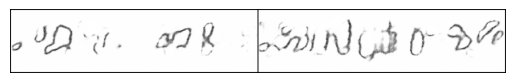

In [ ]:
# 学習する

import datetime
import os
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

project_dir = "./"

train_input_dir = project_dir+'font_data/train/input/'
train_target_dir = project_dir+'font_data/train/target/'

val_input_dir = project_dir+'font_data/val/input/'
val_target_dir = project_dir+'font_data/val/target/'

epoch_dir = project_dir+'output/log/epoch/'
model_dir = project_dir+'output/'
prog_dir = project_dir+'output/prog/'

os.makedirs(os.path.join(epoch_dir), exist_ok=True)
os.makedirs(os.path.join(model_dir), exist_ok=True)
os.makedirs(os.path.join(prog_dir), exist_ok=True)

# Generator (U-Net)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        return self.decoder(x2)


# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x):
        return self.model(x)


# Custom Dataset for loading images
class FontDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))
        assert len(self.input_images) == len(self.target_images), "入力画像とターゲット画像の数が一致していません"

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image = os.path.join(self.input_dir, self.input_images[idx])
        target_image = os.path.join(self.target_dir, self.target_images[idx])

        # 画像をPIL Imageとして開く
        input_image = Image.open(input_image)
        target_image = Image.open(target_image)

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

def tensorDataset(input_dir, target_dir, transform, device):
    """Datasetを全部読み込む"""
    input_images = sorted(os.listdir(input_dir))
    target_images = sorted(os.listdir(target_dir))

    x = []
    y = []
    for i, t in zip(input_images, target_images):
        i, t = os.path.join(input_dir, i), os.path.join(target_dir, t)
        i, t = Image.open(i), Image.open(t)
        if transform:
            i, t = transform(i), transform(t)
        i, t = i.to(device), t.to(device)
        x.append(i)
        y.append(t)
    x, y = torch.stack(x), torch.stack(y)
    return torch.utils.data.TensorDataset(x, y)

def show_image(tensor_image, max_images=16):
    """
    tensor_image : バッチサイズを持つ Tensor (B, C, H, W)
    max_images   : 表示する画像の最大数
    """
    # サブセットを選択
    if tensor_image.size(0) > max_images:
        tensor_image = tensor_image[:max_images]  # 最初の max_images 枚を取得
    # Tensor を CPU に移動し、[0, 1] の範囲に正規化
    tensor_image = tensor_image.detach().cpu()
    tensor_image = (tensor_image + 1) / 2  # Normalize to [0, 1]
    # グリッド画像を作成
    grid = torchvision.utils.make_grid(tensor_image, nrow=4, padding=2, normalize=True)
    # 画像を表示
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    return plt

# Validation loop
def calculate_val_loss(generator, discriminator, val_loader, criterion_GAN, criterion_L1, device):
    generator.eval()  # モデルを評価モードに切り替え
    discriminator.eval()  # モデルを評価モードに切り替え

    val_loss_G = 0
    val_loss_D = 0
    val_steps = len(val_loader)
    gen_output = 0

    with torch.no_grad():  # 勾配計算を行わない
        for input_image, target_image in val_loader:
            input_image, target_image = input_image.to(device), target_image.to(device)

            # Generatorの出力を取得
            gen_output = generator(input_image)

            # Discriminatorの損失
            pred_real = discriminator(torch.cat((input_image, target_image), 1))
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

            pred_fake = discriminator(torch.cat((input_image, gen_output), 1))
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            loss_D = (loss_D_real + loss_D_fake) * 0.5

            # Generatorの損失
            loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
            loss_L1 = criterion_L1(gen_output, target_image) * 100
            loss_G = loss_GAN + loss_L1

            val_loss_G += loss_G.item()
            val_loss_D += loss_D.item()

    return val_loss_G / val_steps, val_loss_D / val_steps, gen_output


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 2  #32
    num_epochs = 10000
    os.makedirs(os.path.join(epoch_dir), exist_ok=True)

    # Transforms
    transform = transforms.Compose([transforms.Resize((128, 512)), transforms.Grayscale(), transforms.ToTensor()])

    # DataLoader setup (訓練データと検証データ)
    #train_dataset = FontDataset(train_input_dir, train_target_dir, transform)
    train_dataset = tensorDataset(train_input_dir, train_target_dir, transform, device)  # データをcuda上に
    #val_dataset = FontDataset(val_input_dir, val_target_dir, transform)  # 同じディレクトリで分割する場合
    val_dataset = tensorDataset(val_input_dir, val_target_dir, transform, device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # 既にcudaにあるので0
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    criterion_GAN = nn.BCEWithLogitsLoss().to(device)
    criterion_L1 = nn.L1Loss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Loss tracking lists
    loss_G_list = []
    loss_D_list = []
    val_loss_G_list = []
    val_loss_D_list = []

    start_time = datetime.datetime.now()
    # Training loop
    for epoch in range(num_epochs):
        generator.train()  # モデルを学習モードに切り替え
        discriminator.train()  # モデルを学習モードに切り替え

        for i, (input_image, target_image) in enumerate(train_loader):
            input_image, target_image = input_image.to(device), target_image.to(device)

            # Generator training
            optimizer_G.zero_grad()
            gen_output = generator(input_image)

            # Discriminator loss
            pred_fake = discriminator(torch.cat((input_image, gen_output), 1))
            loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
            loss_L1 = criterion_L1(gen_output, target_image) * 100
            loss_G = loss_GAN + loss_L1
            loss_G.backward()
            optimizer_G.step()

            # Discriminator training
            optimizer_D.zero_grad()
            pred_real = discriminator(torch.cat((input_image, target_image), 1))
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            pred_fake = discriminator(torch.cat((input_image, gen_output.detach()), 1))
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # Print logs every 100 steps
            if i % 100 == 0:
                # print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss_G: {loss_G.item()}, Loss_D: {loss_D.item()}")
                loss_G_list.append(loss_G.item())
                loss_D_list.append(loss_D.item())

        # Validate and print validation loss
        val_loss_G, val_loss_D, val_output = calculate_val_loss(generator, discriminator, val_loader, criterion_GAN, criterion_L1, device)
        # print(f"Epoch [{epoch}/{num_epochs}], Val Loss_G: {val_loss_G}, Val Loss_D: {val_loss_D}")
        val_loss_G_list.append(val_loss_G)
        val_loss_D_list.append(val_loss_D)

        # Save generated image every 10 epochs
        if (epoch) % 5 == 0:
            elapsed = datetime.datetime.now() - start_time
            remain = elapsed / (epoch+0.001) * num_epochs
            print(f"Epoch [{epoch}/{num_epochs}], Val Loss_G: {val_loss_G}, Val Loss_D: {val_loss_D}, estimate: {remain}")
        if (epoch) % 20 == 0:
            show_image(gen_output).savefig(prog_dir+'gen_output.png', bbox_inches='tight', pad_inches=0)
            show_image(val_output).savefig(prog_dir+'val_output.png', bbox_inches='tight', pad_inches=0)
            # Plotting the loss curves
            plt.figure(figsize=(6, 3))
            plt.plot(loss_G_list, label='t G Loss')
            plt.plot(loss_D_list, label='t D Loss')
            plt.plot(val_loss_G_list, label='v G Loss', linestyle='dashed')
            plt.plot(val_loss_D_list, label='v D Loss', linestyle='dashed')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Generator and Discriminator Losses')
            plt.savefig(prog_dir+'loss_plot.png', dpi=300, bbox_inches='tight')
            plt.show()


        # Save model every 100 epochs
        if (epoch) % 100 == 0:
            torch.save(generator.state_dict(), model_dir+'/generator.'+str(epoch)+'.pth')

    # Final model save
    torch.save(generator.state_dict(), model_dir+'/generator.pth')
    torch.save(discriminator.state_dict(), model_dir+'/discriminator.pth')

if __name__ == '__main__':
    main()


In [36]:
from PIL import Image, ImageDraw, ImageFont
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

# Generator (U-Net) と訓練済みモデルをインポート
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        return self.decoder(x2)

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        return self.decoder(x2)


def generate_image(input_image, model_path, output_image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    generator.eval()
    transform = transforms.Compose([transforms.Resize((128,512)), transforms.ToTensor()])
    input_image = transform(input_image).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_image = generator(input_image)
    return generated_image

def show_image(tensor_image):
    tensor_image = tensor_image.detach().cpu()
    tensor_image = (tensor_image + 1) / 2
    grid = torchvision.utils.make_grid(tensor_image, nrow=4, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

WHITE = (255,255,255)
BLACK = (0,0,0)
def generateInput(text,size,font):
    font_path = "./font_data/font/"+font
    fontPIL = ImageFont.truetype(font_path, size)
    x = 0
    y = -20
    img = Image.new("RGB", (512, 128), WHITE)
    draw = ImageDraw.Draw(img)
    draw.text(xy=(x,y), text=text, fill=BLACK, font=fontPIL)
    return img

In [ ]:
# 使う

if __name__ == '__main__':
    # Paths to the input image, model, and output image
    input_image = generateInput("手書き文字",100,"notosansjp/NotoSansJP-Bold.ttf")
    # input_image.show()
    model_path = "output/generator.200.pth"  # 訓練済みモデルのパス
    output_image_path = "output/generated_image.png"  # 生成された画像の保存先

    # 画像を生成して表示
    output_image = generate_image(input_image, model_path, output_image_path)
    # plt.imshow(input_image)
    # plt.axis('off')
    # plt.show()
    show_image(output_image)